In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
VG = r'D:\Code\implementations\research\CV\Neural Style Transfer\assets\starrynight.jpg'
CHURCH = r'D:\Code\implementations\research\CV\Neural Style Transfer\assets\basilica.jpg'
vg = Image.open(VG)
church = Image.open(CHURCH)
device = torch.device('cuda')

In [3]:
np.random.seed(23)
torch.manual_seed(23)
if str(device) == 'cuda':
    torch.cuda.manual_seed(23)
    torch.cuda.manual_seed_all(23) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

In [4]:
vgg19 = models.vgg19(pretrained=True)
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
net = nn.Sequential(vgg19.features[:14])
net = net.eval().to(device)

In [6]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
  )
)

In [7]:
t = transforms.Compose([
    transforms.Resize((256, 412)),
    transforms.ToTensor(),
])

In [8]:
G = np.random.uniform(0, 1, size = (256, 412, 3)).astype(np.float32)
G = ndimage.filters.median_filter(G, [8, 8, 1])

In [9]:
vg = t(vg)
church = t(church)

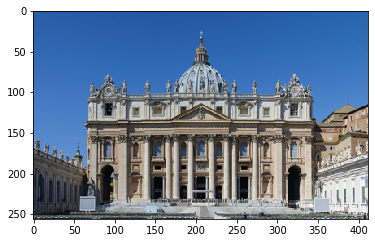

In [10]:
plt.imshow(transforms.ToPILImage()(church))

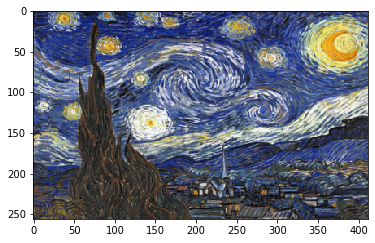

In [11]:
plt.imshow(transforms.ToPILImage()(vg))

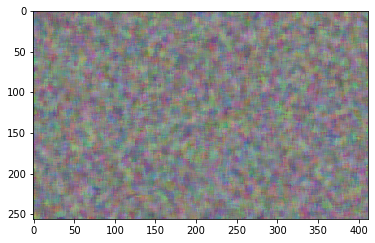

In [12]:
plt.imshow(G)

In [13]:
G = torch.from_numpy(G).permute(2, 0, 1).to(device)
G = Variable(G[None], requires_grad = True)

In [14]:
church = Variable(church[None], requires_grad = False).to(device)
vg = Variable(vg[None], requires_grad = False).to(device)

In [15]:
# Using Hooks
class SaveFeatures():
    features = None
    def __init__(self, module): self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [16]:
activations = [i for i, layer in enumerate(net[0]) if isinstance(layer, nn.Conv2d)]; activations

[0, 2, 5, 7, 10, 12]

In [17]:
def gramMatrix(A):
#     print(list(A.shape))
    b, c, h, w = A.shape
    A = A.view(b*c, -1)
    return torch.mm(A, A.T)

In [18]:
def styleTransfer():
    sf_content = SaveFeatures(list(net[0].children())[activations[-2]])    
    net(church)
    church_encoded = Variable(sf_content.features.clone(), requires_grad = True)
    sf_style = [SaveFeatures(list(net[0].children())[a]) for a in activations]

    net(vg)
    vg_encoded = [Variable(sfi.features.clone(), requires_grad = True) for sfi in sf_style]
    gram_vg = [gramMatrix(tens) for tens in vg_encoded]

    optimizer = torch.optim.SGD([G], lr = 1e-2)
    criterion = nn.MSELoss()

    for epoch in range(900):
        optimizer.zero_grad()
        net(G)
        G_encoded = sf_content.features
        content_loss = criterion(G_encoded, church_encoded) * 7e2
        G_gram = [gramMatrix(sfi.features) for sfi in sf_style]
        style_loss = sum([criterion(g_grami, vg_grami)/g_grami.numel() for g_grami, vg_grami in zip(G_gram, gram_vg)])*1.5
        loss = content_loss + style_loss
        loss.backward(retain_graph = True)
        optimizer.step()
        print(epoch, loss.item(), content_loss.item(), style_loss.item())
    sf_content.close()
    [sf.close() for sf in sf_style]

In [19]:
styleTransfer()

0 55304.7734375 2091.55810546875 53213.21484375
1 19987.41796875 2391.986572265625 17595.431640625
2 9833.1787109375 2598.5712890625 7234.607421875
3 7471.30859375 2503.021728515625 4968.287109375
4 6145.435546875 2640.710693359375 3504.724609375
5 5608.5859375 2532.741943359375 3075.84423828125
6 5190.62744140625 2591.94482421875 2598.6826171875
7 4913.58203125 2508.0029296875 2405.579345703125
8 4680.046875 2524.8759765625 2155.171142578125
9 4490.58154296875 2463.88037109375 2026.701171875
10 4324.259765625 2460.27685546875 1863.982666015625
11 4177.189453125 2413.57958984375 1763.610107421875
12 4043.79931640625 2400.4541015625 1643.34521484375
13 3921.8134765625 2362.545166015625 1559.268310546875
14 3809.3623046875 2345.22314453125 1464.1392822265625
15 3704.9365234375 2312.67236328125 1392.2640380859375
16 3607.951171875 2293.75537109375 1314.1959228515625
17 3517.293701171875 2265.261474609375 1252.0322265625
18 3432.4931640625 2245.76318359375 1186.7298583984375
19 3352.760986

148 1470.90478515625 1225.004638671875 245.90011596679688
149 1467.9453125 1222.5650634765625 245.38018798828125
150 1465.00830078125 1219.990234375 245.01803588867188
151 1462.1058349609375 1217.625 244.48086547851562
152 1459.2215576171875 1215.090087890625 244.13150024414062
153 1456.369384765625 1212.74658203125 243.62274169921875
154 1453.5535888671875 1210.2843017578125 243.26931762695312
155 1450.7703857421875 1207.989013671875 242.78140258789062
156 1448.0030517578125 1205.5517578125 242.45127868652344
157 1445.2786865234375 1203.306884765625 241.97181701660156
158 1442.5728759765625 1200.9173583984375 241.65548706054688
159 1439.8955078125 1198.7022705078125 241.19326782226562
160 1437.2496337890625 1196.3582763671875 240.891357421875
161 1434.63037109375 1194.171630859375 240.45870971679688
162 1432.0377197265625 1191.89111328125 240.14662170410156
163 1429.481201171875 1189.77685546875 239.704345703125
164 1426.9390869140625 1187.5283203125 239.41079711914062
165 1424.432128

290 1221.442626953125 1008.1317138671875 213.31088256835938
291 1220.3798828125 1007.8253784179688 212.55455017089844
292 1219.3232421875 1006.257080078125 213.066162109375
293 1218.2762451171875 1005.9977416992188 212.27847290039062
294 1217.2261962890625 1004.4234619140625 212.80270385742188
295 1216.1915283203125 1004.1221923828125 212.06936645507812
296 1215.166259765625 1002.6138305664062 212.5524444580078
297 1214.1461181640625 1002.3540649414062 211.79200744628906
298 1213.11865234375 1000.8123779296875 212.30633544921875
299 1212.1182861328125 1000.5701293945312 211.54815673828125
300 1211.104736328125 999.0376586914062 212.06707763671875
301 1210.1063232421875 998.759765625 211.3465576171875
302 1209.106689453125 997.2582397460938 211.84849548339844
303 1208.1168212890625 997.0223999023438 211.09442138671875
304 1207.127685546875 995.5020751953125 211.6256561279297
305 1206.14697265625 995.289306640625 210.8577117919922
306 1205.159423828125 993.7471313476562 211.4122467041015

432 1110.465087890625 909.1978759765625 201.26724243164062
433 1109.885986328125 909.636962890625 200.24903869628906
434 1109.3135986328125 908.1763916015625 201.13720703125
435 1108.742919921875 908.6085205078125 200.13436889648438
436 1108.173583984375 907.1536254882812 201.01992797851562
437 1107.6123046875 907.626220703125 199.98611450195312
438 1107.038818359375 906.1369018554688 200.90188598632812
439 1106.4783935546875 906.615234375 199.86314392089844
440 1105.9093017578125 905.162841796875 200.74649047851562
441 1105.354736328125 905.6156616210938 199.7390899658203
442 1104.7850341796875 904.1519775390625 200.6330108642578
443 1104.2376708984375 904.6124877929688 199.6251983642578
444 1103.6732177734375 903.1469116210938 200.52630615234375
445 1103.13427734375 903.64599609375 199.48831176757812
446 1102.5758056640625 902.1817016601562 200.39413452148438
447 1102.032470703125 902.6869506835938 199.34555053710938
448 1101.4747314453125 901.1895751953125 200.28515625
449 1100.9379

574 1044.873046875 850.3695068359375 194.50360107421875
575 1044.50830078125 851.114013671875 193.39430236816406
576 1044.13525390625 849.7149658203125 194.42034912109375
577 1043.77783203125 850.47314453125 193.30471801757812
578 1043.404296875 849.0523681640625 194.35195922851562
579 1043.04736328125 849.8295288085938 193.21786499023438
580 1042.6787109375 848.415771484375 194.26295471191406
581 1042.3165283203125 849.1873168945312 193.12924194335938
582 1041.954833984375 847.7631225585938 194.191650390625
583 1041.6036376953125 848.5242309570312 193.07940673828125
584 1041.2398681640625 847.1196899414062 194.12022399902344
585 1040.8843994140625 847.8991088867188 192.98533630371094
586 1040.52490234375 846.488525390625 194.03634643554688
587 1040.1680908203125 847.2406616210938 192.92745971679688
588 1039.80615234375 845.8626708984375 193.94351196289062
589 1039.454833984375 846.5828857421875 192.87188720703125
590 1039.100830078125 845.2307739257812 193.87001037597656
591 1038.7543

716 1001.1544189453125 811.0516967773438 190.10269165039062
717 1000.902099609375 812.0216064453125 188.8804931640625
718 1000.6326904296875 810.5894165039062 190.04324340820312
719 1000.3754272460938 811.5281982421875 188.84722900390625
720 1000.1182250976562 810.1365966796875 189.98162841796875
721 999.8588256835938 811.06640625 188.79241943359375
722 999.5922241210938 809.6729736328125 189.91925048828125
723 999.339599609375 810.587158203125 188.75244140625
724 999.07470703125 809.2210693359375 189.85360717773438
725 998.8233032226562 810.11328125 188.7100067138672
726 998.562255859375 808.7515869140625 189.8106689453125
727 998.3108520507812 809.6429443359375 188.6678924560547
728 998.0519409179688 808.2793579101562 189.77259826660156
729 997.802978515625 809.1843872070312 188.61856079101562
730 997.547119140625 807.8146362304688 189.73248291015625
731 997.296875 808.740234375 188.55667114257812
732 997.04248046875 807.341552734375 189.70094299316406
733 996.7928466796875 808.27612

860 969.1419677734375 782.2821044921875 186.85984802246094
861 968.960693359375 783.3211669921875 185.6395263671875
862 968.7621459960938 781.94189453125 186.8202667236328
863 968.5778198242188 782.9771118164062 185.6007080078125
864 968.3770141601562 781.6085815429688 186.76844787597656
865 968.1951904296875 782.6076049804688 185.58758544921875
866 968.0009155273438 781.2838745117188 186.71702575683594
867 967.82080078125 782.2676391601562 185.55319213867188
868 967.623046875 780.9301147460938 186.69293212890625
869 967.4427490234375 781.9728393554688 185.46987915039062
870 967.2467041015625 780.6040649414062 186.6426239013672
871 967.0704345703125 781.6074829101562 185.46295166015625
872 966.8778076171875 780.2652587890625 186.61257934570312
873 966.6998901367188 781.2844848632812 185.41542053222656
874 966.5089721679688 779.9189453125 186.59002685546875
875 966.3280029296875 780.9613647460938 185.36666870117188
876 966.1375732421875 779.6044311523438 186.5331573486328
877 965.966369

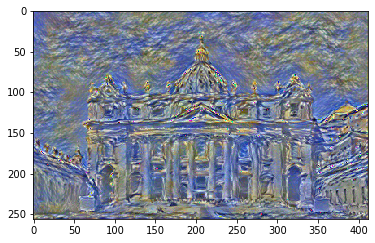

In [20]:
plt.imshow(transforms.ToPILImage()(G.cpu().detach()[0]))    